# Сеть фитнес-центров

Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов.

Чтобы бороться с оттоком, отдел по работе с клиентами фитнес-центра перевёл в электронный вид множество клиентских анкет. Наша задача — провести анализ и подготовить план действий по удержанию клиентов. А именно:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
 - 1) выделить целевые группы клиентов;
 - 2) предложить меры по снижению оттока;
 - 3) определить другие особенности взаимодействия с клиентами.

План исследования:
1. Загрузим данные;
2. Проведем исследовательский анализ данных (EDA);
3. Построим модель прогнозирования оттока клиентов;
4. Сделаем кластеризацию клиентов;
5. Сформулируем выводы и сделаем базовые рекомендации по работе с клиентами.

Сеть фитнес-клубов предоставила сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц.

## Загрузка данных

In [1]:
# импортируем необходимые для исследования библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
# прочитаем файл и передадим его переменной
dt = pd.read_csv('/datasets/gym_churn.csv')
dt.info()
dt.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


 Набор данных включает следующие поля:
 - Данные клиента за предыдущий до проверки факта оттока месяц:
  - `gender` — пол;
  - `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
  - `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
  - `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
  - `Phone` — наличие контактного телефона;
  - `Age` — возраст;
  - `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).
 - Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
  - `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
  - `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
  - `Group_visits` — факт посещения групповых занятий;
  - `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
  - `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
  - `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
  - `Churn` — факт оттока в текущем месяце.
  
Приведем наименования столбцов к нижнему регистру:

In [3]:
# приведем к нижнему регистру названия столбцов
dt.columns = dt.columns.str.lower()
dt.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

## EDA

In [4]:
dt.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


В данных нет отсутствующих признаков. Аномалий также не обнаружено.

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался. Построим столбчатые гистограммы и распределения признаков для обеих групп:

Количество ушедших в отток: 1061 Доля: 0.27
Количество оставшихся: 2939 Доля: 0.73


churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


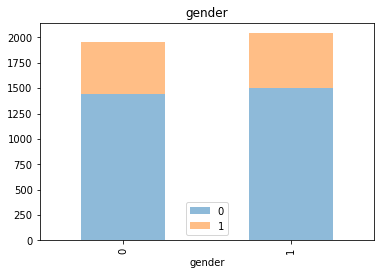

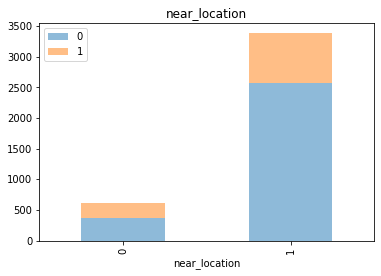

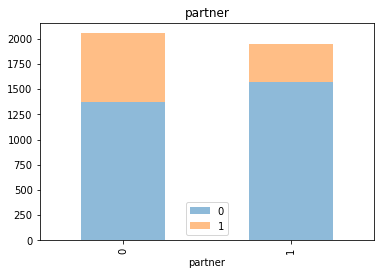

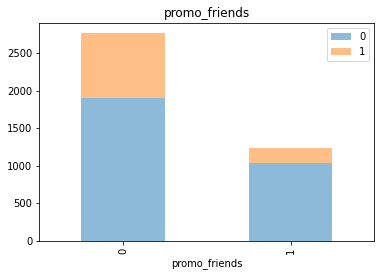

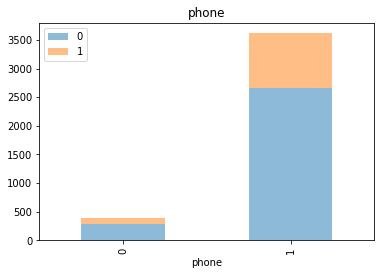

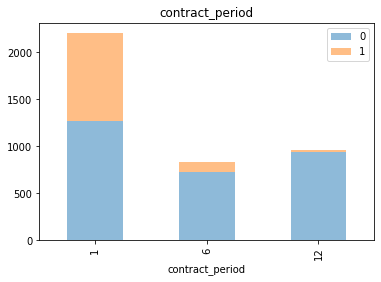

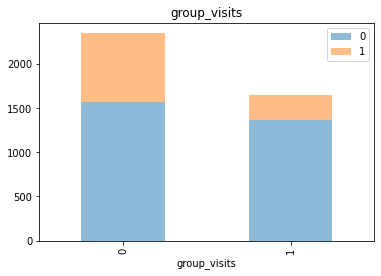

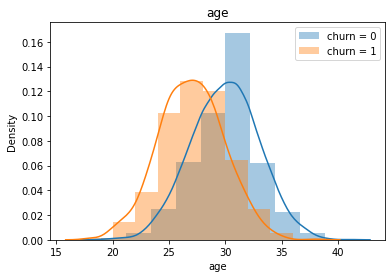

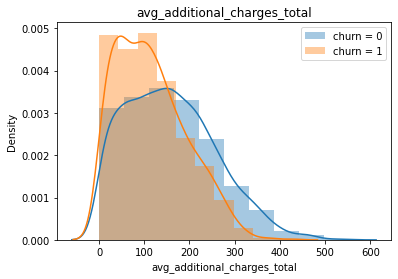

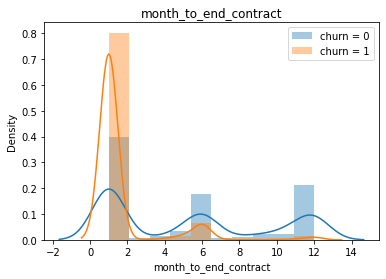

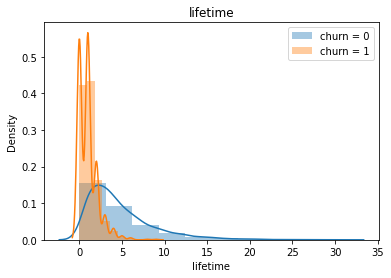

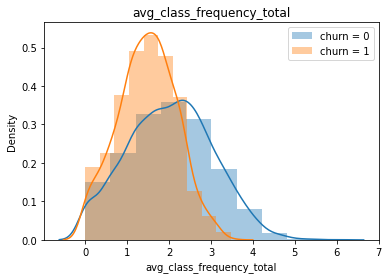

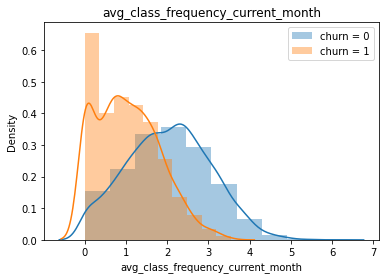

In [5]:
print(
    'Количество ушедших в отток:', dt['churn'].sum(),
    'Доля:', (dt['churn'].sum()/dt['churn'].count()).round(2)
)
print(
    'Количество оставшихся:', dt['churn'].count() - dt['churn'].sum(),
    'Доля:', 1 - (dt['churn'].sum()/dt['churn'].count()).round(2)
)
display(dt.groupby('churn').mean().T.style.background_gradient(cmap='Blues', axis=1))

# зададим функцию для построения графиков
def feat_hist(x, group_col, key_cols):
    x_new = x.copy()[key_cols]
    for c in key_cols:
 
        if c == group_col: continue
 
        if len(x_new[c].unique()) < 10:
            report = x_new.reset_index().pivot_table(index=c, columns=group_col, values='index', aggfunc='count')
            report.plot(kind='bar', stacked=True, alpha=0.5)
 
        else:
            for c1 in x[group_col].unique():
                sns.distplot(x_new[x_new[group_col] == c1][c],
                             label = '{} = {}'.format(group_col, str(c1)), bins=10)
 
        plt.title(c)
        plt.legend()
        plt.show()
 
feat_hist(dt, 'churn', dt.columns)

Средние значения в группе ушедших в отток, ниже практически по всем признакам превышает группу тех кто остался.

Примечательно:
- среднее значение времени с момента первого обращения в фитнес-центр в группе попавших в отток составляет меньше одного месяца (0.99), ситуация с группой тех кто остался значительно выше в данном показателе, среднее по данному признаку выше почти в 5 раз (4.71);
- доля посетителей групповых занятий попавших в отток в два раза почти в 2 раза ниже, тех кто остался (26% и 46% соответственно);
- средний возраст оставшихся клиентов - 30 лет, попавших в отток - 27 лет;
- доля клиентов-сотрудников компаний-партнеров клуба и пришедших в рамках акции "приведи друга" выше в группе оставшихся примерно на 20% по обоим параметрам.


Построим матрицу корреляций:

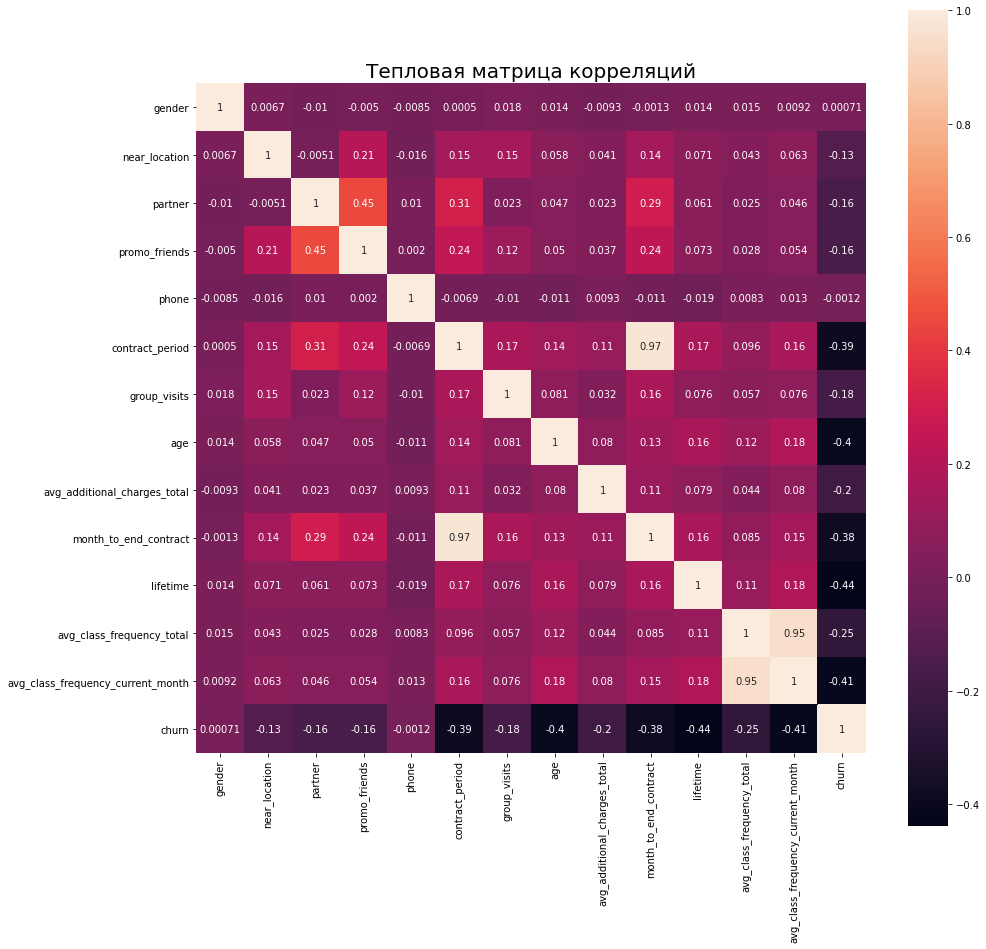

In [6]:
# корреляционная матрица
corr_m = dt.corr()

# отобразим heatmap
plt.figure(figsize = (15,15))
sns.heatmap(corr_m,
    square = True,
    annot = True
)
plt.title('Тепловая матрица корреляций', fontsize=20)
plt.show()

Из тепловой матрицы видно, что в данных присутствует две пары мультиколлинеарных параметров:
- `contract_period` и `month_to_end_contract`;
- `avg_class_frequency_total` и `avg_class_frequency_current_month`.

Для более точной работы достаточно удалить только один параметр из каждой пары, такми образом мы избавимся от мультиколлинеарности.

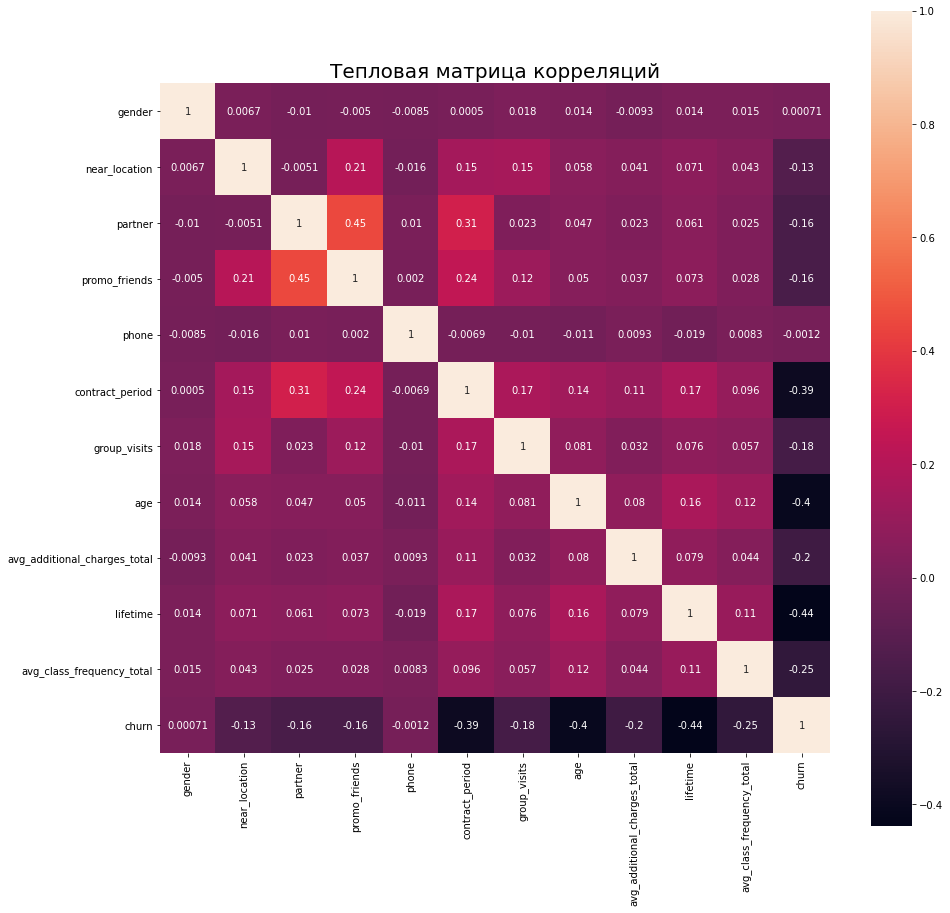

In [7]:
# удаляем мултиколлинеарные признаки
dt = dt.drop(['month_to_end_contract', 'avg_class_frequency_current_month'], axis=1)

# корреляционная матрица
corr_m = dt.corr()

# отобразим heatmap
plt.figure(figsize = (15,15))
sns.heatmap(corr_m,
    square = True,
    annot = True
)

plt.title('Тепловая матрица корреляций', fontsize=20)
plt.show()

От мультиколлинеарности избавились. Приступим к прогнозированию.

## Модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце, а для этого:
- Разбьем данные на обучающую и валидационную выборку функцией `train_test_split()`.
- Обучим модель на train-выборке двумя способами:
 - логистической регрессией,
 - случайным лесом.
- Оценим метрики `accuracy`, `precision` и `recall` для обеих моделей на валидационной выборке. Сравним по ним модели. Ответим на вопрос - какая модель показала себя лучше на основании метрик?

In [8]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X = dt.drop('churn', axis = 1)
y = dt['churn']

In [9]:
# разделяем модель на обучающую и валидационную выборку (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# стандартизируем данные 
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

# задим алгоритм для модели логистической регрессии
model = LogisticRegression(solver='liblinear')

# обучаем модель
model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
predictions = model.predict(X_test_st)
probabilities = model.predict_proba(X_test_st)[:,1]

print('Метрики для модели "Логистическая регрессиея"')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))

# задим алгоритм для модели случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train_st, y_train)
rf_pred = rf_model.predict(X_test_st)

print(' ')
print('Метрики для модели "Случайный лес"')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_pred)))

Метрики для модели "Логистическая регрессиея"
Accuracy: 0.90
Precision: 0.79
Recall: 0.81
 
Метрики для модели "Случайный лес"
Accuracy: 0.89
Precision: 0.79
Recall: 0.76


На основании метрик, можно сказать, что модель "Логистическая регрессия" показала себя лучше. Доля правильных ответов 90%, точность в обеих маделях равна 79%, полнота в логистической регрессии выше 80%.

## Кластеризация клиентов

Отложим в сторону столбец с оттоком и проведем кластеризацию объектов (клиентов):
- Стандартизируем данные.
- Построим матрицу расстояний функцией `linkage()` на стандартизованной матрице признаков и нарисуем дендрограмму. На основании полученного графика предположим, какое количество кластеров можно выделить.
- Обучим модель кластеризации на основании алгоритма `K-Means` и спрогнозируем кластеры клиентов.
- Посмотрим на средние значения признаков для кластеров.
- Построим распределения признаков для кластеров.
- Для каждого полученного кластера посчитаем долю оттока. Ответим на вопросы: Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

In [10]:
# отбросим столбец с оттоком
dt_new = dt.drop('churn', axis = 1)
dt_new.head(1)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total
0,1,1,1,1,0,6,1,29,14.22747,3,0.020398


Стандартизируем данные:

In [11]:
# стандартизация данных перед работой с алгоритмами
sc = StandardScaler()
X_sc = scaler.fit_transform(dt)

Посмотрим матрицу расстояний и нарисуем дендрограмму:

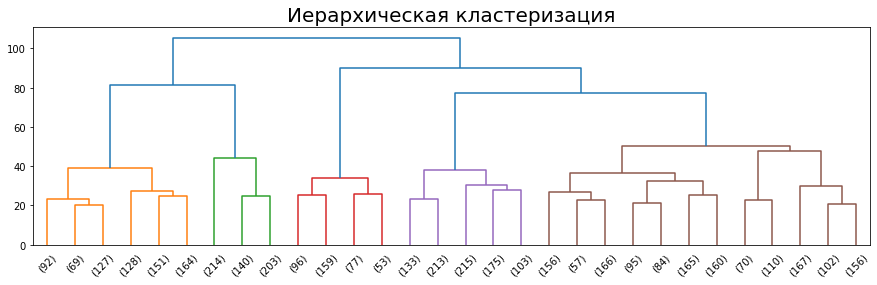

In [12]:
# построим матрицу расстояний
linked = linkage(X_sc, method = 'ward')

# построим дендрограмму
plt.figure(figsize=(15, 4))  
dendrogram(linked, orientation='top', truncate_mode = 'lastp')
plt.title('Иерархическая кластеризация', fontsize=20)
plt.show() 

Предложенное оптимальное число кластеров 5 — пять разных вариаций цвета на графике.

Обучим модель кластеризации на основании алгоритма `K-Means` и спрогнозируем кластеры клиентов:

In [13]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)

# прогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc)

Посмотрим на средние значения признаков для кластеров. Построим распределения признаков для кластеров. По бинарным признакам построим гистограммы, а по остальным боксплоты:

Количество клиентов в кластере 1: 602  | Доля: 0.15
Количество клиентов в кластере 2: 1090 | Доля: 0.27
Количество клиентов в кластере 3: 936  | Доля: 0.23
Количество клиентов в кластере 4: 571  | Доля: 0.14
Количество клиентов в кластере 5: 801  | Доля: 0.2


,0,1,2,3,4
cluster_km,0.000000,1.000000,2.000000,3.000000,4.000000
gender,0.501661,0.522936,0.503205,0.502627,0.513109
near_location,0.000000,0.999083,0.992521,0.984238,1.000000
partner,0.481728,0.161468,0.916667,0.626970,0.330836
promo_friends,0.071429,0.074312,1.000000,0.000000,0.217228
phone,0.911960,0.902752,0.903846,0.900175,0.900125
contract_period,2.872093,2.068807,7.827991,10.623468,1.682896
group_visits,0.224252,0.450459,0.544872,0.492119,0.289638
age,28.652824,30.055963,29.950855,29.996497,26.922597
avg_additional_charges_total,135.994298,157.510111,159.006129,164.623351,114.095697


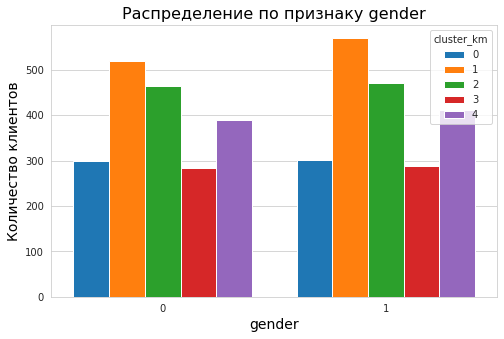

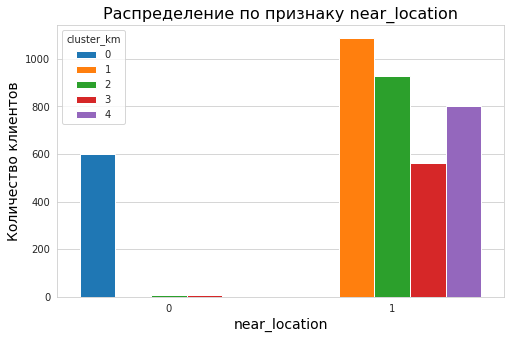

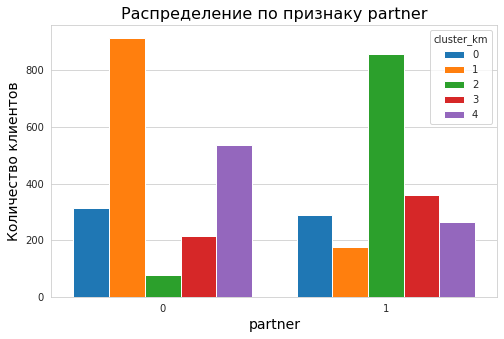

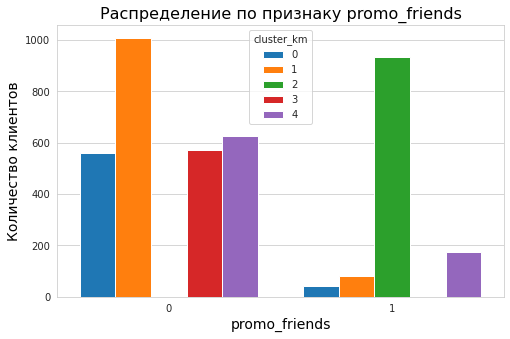

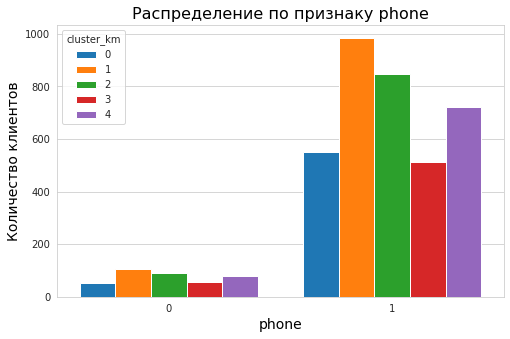

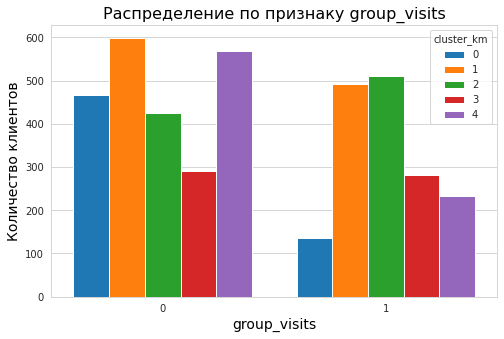

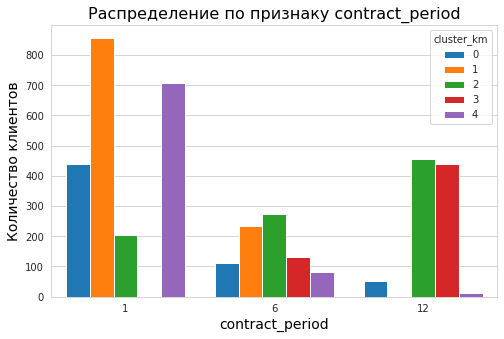

Распределение кластеров по признаку age 


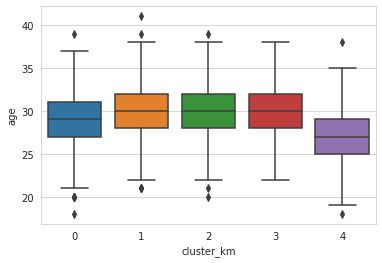

Распределение кластеров по признаку avg_additional_charges_total 


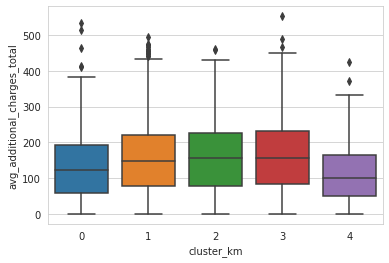

Распределение кластеров по признаку lifetime 


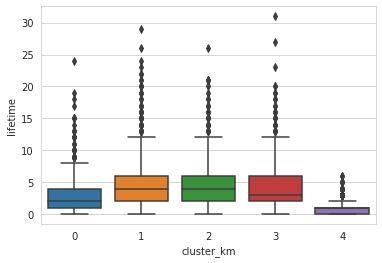

Распределение кластеров по признаку avg_class_frequency_total 


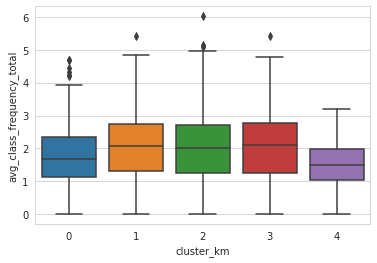

In [14]:
# сохраняем метки кластера в поле нашего датасета
dt_new['cluster_km'] = labels

cluster_count = dt_new.groupby('cluster_km').count().reset_index()
print('Количество клиентов в кластере 1:', cluster_count.iat[0,1]
      , ' |' , 'Доля:', (cluster_count.iat[0,1]/cluster_count['gender'].sum()).round(2))
print('Количество клиентов в кластере 2:', cluster_count.iat[1,1]
      , '|' , 'Доля:', (cluster_count.iat[1,1]/cluster_count['gender'].sum()).round(2))
print('Количество клиентов в кластере 3:', cluster_count.iat[2,1]
      , ' |' , 'Доля:', (cluster_count.iat[2,1]/cluster_count['gender'].sum()).round(2))
print('Количество клиентов в кластере 4:', cluster_count.iat[3,1]
      , ' |' , 'Доля:', (cluster_count.iat[3,1]/cluster_count['gender'].sum()).round(2))
print('Количество клиентов в кластере 5:', cluster_count.iat[4,1]
      , ' |' , 'Доля:', (cluster_count.iat[4,1]/cluster_count['gender'].sum()).round(2))

# выводим статистику по средним значениям наших признаков по кластеру
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: lightblue' if v else '' for v in is_max]
dt_new_cluster_km = dt_new.groupby(
    'cluster_km').mean().reset_index().T.style.apply(highlight_max, axis = 1)
display(dt_new_cluster_km)

# построим распределения по бинарным признакам
for column in [
    'gender', 'near_location', 'partner', 'promo_friends', 'phone',
    'group_visits', 'contract_period'
]:
    plt.figure(figsize=(8,5))
    sns.set_style(style="whitegrid")
    ax = sns.countplot(data=dt_new, x = dt_new[column], hue='cluster_km', saturation=1)
    ax.set_title('Распределение по признаку '  +column, fontsize = 16, color = 'black')
    plt.ylabel('Количество клиентов', fontsize = 14, color = 'black')
    plt.xlabel(column, fontsize = 14, color = 'black')
plt.show()

# построим боксплоты по остальным признакам
for column in ['age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total']:
    print(f'Распределение кластеров по признаку {column} ')
    sns.boxplot(x = 'cluster_km', y = dt_new[column], data = dt_new)
    plt.show()

- По гендерному признаку отличий между кластерами нет;
- В кластере 1 нет клиентов проживающих или работающих в районе, где находится фитнес-центр, по остальным кластерам ситуация иная, практически 100% клиентов проживают или работают в непосредственной близости;
- меньше всего клиентов являющихся сотрудниками компаний-партнеров в кластере 2 - 16%, больше всего в кластере 3 - 92%;
- в кластере 4 нет клиентов пришедших по промо-акции "приведи друга", кластер 3 целиком состоит из клиентов привлеченных по данной акции;
- наименьшая длительность абонементов в кластере 5, наибольшее в кластере 4;
- кластер 3 на 54% состоит из клиентов посещающих групповые занятия, также стоит отметить, что кластеры 2 и 4 имеют высокую долю по данному признаку - 45% и 49% соответственно;
- средний возраст клиентов 2, 3 и 4 кластеров - 30 лет, наименьший показатель в кластере 5 - 27 лет;
- наибольшую суммарную выручку от прочих услуг фитнес-центра приносят клиенты кластера 4. Клиенты кластера 2 и 3 также имеют высокий показатель по данному параметру;
- среднее значение времени с момента первого обращения в фитнес-центр в кластере 5 составляет меньше одного месяца (0.96) - это наименьший результат по кластерам, наилучшим образом по данному параметру себя показывают кластеры 2, 3 и 4 (4.83, 4.70, 4.65 месяца соответственно);
- средняя частота посещений в неделю в кластере 5 составляет 1.48 - это наименьший результат по кластерам, наилучше по данному параметру кластеры 2, 3 и 4 (2.04, 2.01 и 2.03 посещений соответственно).

Посчитаем долю оттока по каждому кластеру:

In [15]:
dt['cluster_km'] = labels
dt.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn,cluster_km
0,1,1,1,1,0,6,1,29,14.227470,3,0.020398,0,2
1,0,1,0,0,1,12,1,31,113.202938,7,1.922936,0,3
2,0,1,1,0,1,1,0,28,129.448479,2,1.859098,0,1
3,0,1,1,1,1,12,1,33,62.669863,2,3.205633,0,2
4,1,1,1,1,1,1,0,26,198.362265,3,1.113884,0,2


In [16]:
print('Доля оттока по кластерам:')
dt.groupby('cluster_km').agg({'churn':'mean'}).rename(columns={'churn':'churn_%'}).reset_index()

Доля оттока по кластерам:


,cluster_km,churn_%
0,0,0.408638
1,1,0.001835
2,2,0.011752
3,3,0.005254
4,4,0.997503


Наиболее склонный к оттоку кластер 5, практически 100% клиентов. Кластер 1 имеет долю оттока 41%. Все остальные кластеры, по данному показателю, являются надежными.

## Выводы и базовые рекомендации по работе с клиентами

**На основании проведенного исследования составим портреты целевых групп клиентов фитнес-центра:**
- 1 группа:
 - проживающие за пределами района, в котором располагается фитнес-клуб;
 - половина клиентов данной группы - это сотрудники компаний-партнеров;
 - средний возраст 28.6 лет;
 - доля оттока - 40%;
 - доля группы от общего количества клиентов клиентов - 15%.
 
- 2 группа:
 - проживающие или работающие в районе расположения фитнес-клуба;
 - наименьшее количество клиентов являющихся сотрудниками компаний-партнеров - 16%;
 - почти половина посещает групповые занятия;
 - высокая выручка от прочих услуг фитнес-центра;
 - наибольшее, среди групп, значение среднего времени с момента первого обращения в фитнес-центр - 4.83 месяца;
 - средняя частота посещений в неделю - 2.04;
 - средний возраст 30 лет;
 - нулевая доля оттока;
 - доля группы от общего количества клиентов клиентов - 27%.
 
- 3 группа:
 - проживающие или работающие в районе расположения фитнес-клуба;
 - привлечены по промо-акции "приведи друга";
 - наибольшее количество клиентов являющихся сотрудниками компаний-партнеров - 92%;
 - больше половины посещает групповые занятия - 54%;
 - высокая выручка от прочих услуг фитнес-центра;
 - высокое значение среднего времени с момента первого обращения в фитнес-центр - 4.7 месяца;
 - средняя частота посещений в неделю - 2.01;
 - средний возраст 30 лет;
 - почти нулевая доля оттока - 1%;
 - доля группы от общего количества клиентов клиентов - 23%.
 
- 4 группа:
 - проживающие или работающие в районе расположения фитнес-клуба;
 - отсутствие привлеченных по промо-акции "приведи друга";
 - наибольшая, среди групп, средняя длительность абонемента - 10.6 месяцев;
 - почти половина посещает групповые занятия;
 - наибольшая, среди групп, выручка от прочих услуг фитнес-центра;
 - высокое значение среднего времени с момента первого обращения в фитнес-центр - 4.65 месяца;
 - средняя частота посещений в неделю - 2.03;
 - средний возраст 30 лет;
 - нулевая доля оттока;
 - доля группы от общего количества клиентов клиентов - 14%.
 
- 5 группа:
 - проживающие или работающие в районе расположения фитнес-клуба;
 - наибольше, среди групп, среднее значение длительности абонемента - 1.7 месяца;
 - наименьшая, среди групп, выручка от прочих услуг фитнес-центра;
 - наименьшее, среди групп, среднее значение времени с момента первого обращения в фитнес-центр - 0.96 месяца;
 - наименьшая, среди групп, средняя частота посещений в неделю - 1.48;
 - средний возраст 27 лет;
 - максимальная, среди групп, доля оттока - 99.7%;
 - доля группы от общего количества клиентов клиентов - 20%.
 
 
 **Исходя из составленных выше портретов целевых групп, можем предложить следующие рекомендации:**
 1. Фитнес-центр имеет несколько групп которые имеют долю 64% (группы 2, 3 и 4) от общего количества клиентов, у них высокий уровень лояльности, это объясняется высокой доходностью с прочих услуг, высоким значением среднего времени и почти нулевой долей оттока. Логично в данном случае организовать маркетинговую компанию, направленную на привлечение клиентов относящихся, по признакам, к данным группам. 
 2. Провести анализ конкурентов по рейтингам и отзывам на общедоступных и популярных интрнет-ресурсах. После чего выбрать фитнес-клубы с высокими оценками и положительными отзывами. Затем можно использовать "контрольную закупку", чтобы посмотреть работу конкурентов глазами клиента и на основании этого понять как можно за "хантить" клиентов или качетственных сотрудников (ни для кого не секрет, что в фитнес-клубах выжную роль играет квалифицированный, современный персонал).  
 3. Целевая группа №5 имеет показатель оттока почти 100%, при том ее доля составляет 20% от общего количества клиентов. Средний возраст в данной группе - 27 лет. Пересмотреть/разработать (если отсутствует) программу лояльности для младших возрастных категорий, очевидно, что если она есть, то плохо работает на удержание клиента.
 4. По имеющимся данным отражена активность только лишь по одной промо-акции "приведи друга". Если блок предложений в сфере "промо" представлен только в одном варианте - это может быть причиной потери части клиентов, которые предпочтут конкурентов. К тому же, такое промо, как например "3 месяца по цене 2-х" или "6 месяцев по цене 4-х" отлично работает в сфере предоставления услуг фитнес-центров. Ориентированны такие акции, как на повышение лояльности постоянных клиентов, так и на получение дополнительной прибыли с клиентов которые "начинают с понедельника" совершают покупку, после чего теряются по какой-либо причине, оплатив услуги которыми впоследствии не воспользуются.